# Classifying Names with a Character-Level RNN
### Author: Sean Robertson

We will be building a basic character level RNN to classify words 

Read it here 
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

1. read the words as a series of characters 

2. output a prediction and hidden state at each step 

3. feed the previous hidden state at each next step

Take the final prediction as the output i.e., the class the word 
belongs to 

Specifically, we’ll train on a few thousand surnames from 18 languages 
of origin, and predict which language a name is from based on the spelling:



## Preparing the data


Included in the data/names directory are 18 text files names as "Language.txt"

Each of the file contains a bunch of names one name per line. Construct a dictionary of lists of names per language 


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))


['data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters

57

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))


Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    
    """
    
    read each of the file individually 
    read the category name and append it to the dict all_categories 
    read the lines in the particulat text file 
    save it as lines 
    
    lines is a dictionary
    whose length is the number of words of that language 
    add all these words (after unicode conversion) 
    to the category_lines dictionary
    
    here category_lines[category] = lines 
    
    so it is like 
    
    category_lines [ english : line1, french : line2, etc]
    
    """
    
    print(filename)
    category = os.path.splitext(os.path.basename(filename))[0]
    print(category)
    all_categories.append(category)
    lines = readLines(filename)
    print(type(lines), len(lines))
    category_lines[category] = lines

n_categories = len(all_categories)
print("Number of categories: {}".format(n_categories))


data/names/Spanish.txt
Spanish
<class 'list'> 298
data/names/Arabic.txt
Arabic
<class 'list'> 2000
data/names/Greek.txt
Greek
<class 'list'> 203
data/names/Polish.txt
Polish
<class 'list'> 139
data/names/Czech.txt
Czech
<class 'list'> 519
data/names/Chinese.txt
Chinese
<class 'list'> 268
data/names/Russian.txt
Russian
<class 'list'> 9408
data/names/Vietnamese.txt
Vietnamese
<class 'list'> 73
data/names/German.txt
German
<class 'list'> 724
data/names/Scottish.txt
Scottish
<class 'list'> 100
data/names/Korean.txt
Korean
<class 'list'> 94
data/names/English.txt
English
<class 'list'> 3668
data/names/Japanese.txt
Japanese
<class 'list'> 991
data/names/French.txt
French
<class 'list'> 277
data/names/Italian.txt
Italian
<class 'list'> 709
data/names/Dutch.txt
Dutch
<class 'list'> 297
data/names/Portuguese.txt
Portuguese
<class 'list'> 74
data/names/Irish.txt
Irish
<class 'list'> 232
Number of categories: 18


In [6]:
print(lines[:5])

['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis']


Now we have category_lines, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
all_categories (just a list of languages) and n_categories for
later reference.

In [7]:
print(category_lines['Italian'][-5:])

['Zappa', 'Zeni', 'Zini', 'Zino', 'Zunino']


## Turning Names into Tensors

Now that we have all the names organized we will need to 
turn them into tensors

> single letter = one-hot vector = 1 X n_letters

> word = line_length X 1 X n_letters 

> extra 1 means batch size = 1 

In [8]:
import torch
import torch.optim as optim

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    
    """
    
    find the index of the letter 
    in the vocab all_letters
    
    """
    
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    
    """
    
    a letter is represented as 1 X n_letters
    we are first creating a tensor of size with zeros 
    1 X n_letters 
    then only the index which corresponds to that letter 
    is made as 1 the rest of them are kept the same as 0
    return the tensor
    
    """
    
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    
    """
    
    this is basically doing the work of letterToTensor
    in much faster fashion
    
    the size of the tensor is (no of letters in word) X 1 X n_letters 
    li is the no of letters in word 
    letter is a single letter 
    
    the second dim is the batch size 
    so the second dim is "1" here 
    """
    
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        #print(li, letter)
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor("A").topk(1))
print(letterToTensor("A").topk(1))
print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
(tensor([[[1.]]]), tensor([[[26]]]))
(tensor([[1.]]), tensor([[26]]))
torch.Size([5, 1, 57])


# Creating the Network

<img src="data/Z2xbySO.png">

See the tutorial there [creating recurrent neural networks]("https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#creating-the-network")

Just two linear layers which operate on an input and hidden state with a logsoftmax layer at the end

> [input,hidden] --> [combined] (basically concatenation)

> [combined] --> i2o --> softmax --> [output]

> [combined] --> i2h --> [hidden]

To run a step on this network we need to pass an input and a previous hidden state (which we will initialize first 
with zeros). We get back the output(probability of each language)and a next hidden state (which we keep for the next step). Check that one of the input of the forward step is hidden


In [10]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        print("i2h: {}".format(self.i2h))
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        print("i2o: {}".format(self.i2o))
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        
        """
        to initialize the hidden states to zeros 
        """
        
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

i2h: Linear(in_features=185, out_features=128, bias=True)
i2o: Linear(in_features=185, out_features=18, bias=True)


In [13]:
print(rnn)

input = letterToTensor('A')

hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
print(next_hidden)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
tensor([[-2.8923, -2.8770, -2.9744, -2.8331, -2.9474, -2.8876, -2.8456, -2.8971,
         -2.8440, -2.9596, -2.8173, -2.8724, -2.8339, -2.9680, -2.9365, -2.8740,
         -2.8652, -2.9222]], grad_fn=<LogSoftmaxBackward>)
tensor([[-0.0147,  0.0475, -0.0534, -0.0070, -0.0675, -0.0229, -0.0926, -0.0110,
         -0.0287, -0.1374,  0.0031,  0.0343, -0.0984, -0.0948, -0.1127, -0.0215,
          0.0713, -0.0985, -0.1153,  0.0637, -0.0386,  0.1128,  0.0428, -0.1036,
          0.0864,  0.0565, -0.0937,  0.0434,  0.0191,  0.1259,  0.0372,  0.0720,
          0.0472, -0.0208, -0.0260,  0.0151, -0.0340, -0.0409,  0.0269,  0.0665,
          0.0409,  0.0311,  0.1387,  0.0069,  0.0317, -0.0490, -0.0814, -0.1225,
         -0.0174,  0.0566,  0.0088,  0.1115,  0.0855,  0.0826,  0.0769,  0.0864,
          0.0275,  0.0586, -0.0882, -0.0952,  0.0145, -0

In [17]:
"""

For the sake of efficiency we don’t want to be creating a new 
Tensor for every step, so we will use lineToTensor instead of 
letterToTensor and use slices. This could be further optimized 
by pre-computing batches of Tensors.

slices mean we will be taking one word each at a time

"""

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(input[0])
print(input[0].shape)
print(output)
print(output.shape)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])
tensor([[-2.8923, -2.8770, -2.9744, -2.8331, -2.9474, -2.8876, -2.8456, -2.8971,
         -2.8440, -2.9596, -2.8173, -2.8724, -2.8339, -2.9680, -2.9365, -2.8740,
         -2.8652, -2.9222]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 18])


# Training
# Preparing for Training

In [20]:
"""

a function to interpret the output of the network
which we know to be a likelihood of each category

we can use Tensor.topk to get the index of the greatest
value

output is 1 X no of cat vector 

check below how this function behaves

"""

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 10)


In [21]:
print(output.shape)

top_n, top_i = output.topk(1)

print(top_n)
print(top_i)

category_i = top_i[0].item()
print(category_i)

print(all_categories[category_i])

torch.Size([1, 18])
tensor([[-2.8173]], grad_fn=<TopkBackward>)
tensor([[10]])
10
Korean


In [25]:
"""

a quick way to get the training example
this is basically 
a name and its language 

"""

import random

def randomChoice(l):
    """
    returns a random number 
    to sample from a particular language file
    """
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    
    """
    category is a random category generated from 
    which we will sample the training sample
    eg category = "Dutch"
    
    again we will sample a random word from that selected language file 
    we will save the random word as line 
    
    category_tensor is basically the target tensor
    suppose category = 'Durch'
    then all_categories.index(category) = "1"
    
    line_tensor is of dimension no of words in line X 1 X n_letters 
    
    we will return everything
    """
    
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    #print(line_tensor.shape)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Vietnamese / line = Chung
category = Chinese / line = Zhang
category = Vietnamese / line = Luong
category = Chinese / line = Gao
category = Japanese / line = Teshima
category = Japanese / line = Kawasaki
category = Japanese / line = Takemura
category = Irish / line = Fergus
category = Dutch / line = Rademaker
category = Scottish / line = Gray


In [26]:
all_categories.index('Czech')

4

# Training the Network


In [27]:
"""

Now all it takes to train the network is show it a 
bunch of examples have it make guesses and tell if its 
wrong

we use NLL loss since the last layer of the RNN is 
nn.LogSoftmax

"""

criterion = nn.NLLLoss()

In [28]:
"""

Each loop of training will:

    (1) Create input and target tensors
    (2) Create a zero initial hidden state
    (3) Read each letter in and
    (4) Keep hidden state for next letter
    (5) Compare final output to target
    (6) Back-propagate
    (7) Return the output and loss

"""

# If you set this too high, it might explode. 
# If too low, it might not learn
learning_rate = 0.005 

optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    loss.backward()
    
    """
    # Add parameters' gradients to their values, 
    #multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    """
    
    optimizer.step()
    
    return output, loss.item()


In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()


for iter in range(1, n_iters + 1):
    
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    output, loss = train(category_tensor, line_tensor)
    
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % 
              (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0



5000 5% (0m 9s) 2.6491 Henderson / Russian ✗ (Scottish)
10000 10% (0m 18s) 1.9665 Uggeri / Italian ✓
15000 15% (0m 27s) 3.4030 Fabian / Arabic ✗ (French)
20000 20% (0m 36s) 0.9325 Achthoven / Dutch ✓
25000 25% (0m 45s) 0.8908 Tong / Vietnamese ✓
30000 30% (0m 55s) 5.2624 Mas / Chinese ✗ (German)
35000 35% (1m 4s) 0.5179 Tassioglou / Greek ✓
40000 40% (1m 13s) 0.5036 Bilias / Greek ✓
45000 45% (1m 21s) 2.8412 Rory / English ✗ (Irish)
50000 50% (1m 30s) 1.3459 Krytinar / Czech ✓
55000 55% (1m 39s) 1.3200 Abreu / Portuguese ✓
60000 60% (1m 48s) 0.7616 Bei / Chinese ✓
65000 65% (1m 57s) 0.4709 Perreault / French ✓
70000 70% (2m 6s) 0.6667 D'cruze / Portuguese ✓
75000 75% (2m 15s) 0.9722 Garcia / Portuguese ✓
80000 80% (2m 24s) 1.2995 Teoh / Chinese ✓
85000 85% (2m 33s) 1.4630 Battaglia / Greek ✗ (Italian)
90000 90% (2m 41s) 1.3339 Vacca / Czech ✗ (Italian)
95000 95% (2m 51s) 1.5531 Oleastro / Italian ✗ (Spanish)
100000 100% (3m 0s) 1.4474 Abreu / Portuguese ✓


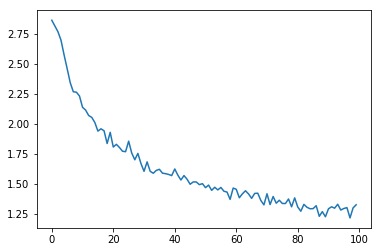

In [31]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()


# # Evaluating the Results



To see how well the network performs on different categories we will create a confusion matrix indicating for every actual language (rows) which language the network guesses (columns).

To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

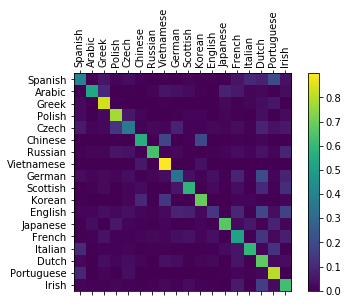

In [36]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Running on User Input

In [42]:

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satosh')
predict('Maldini')



> Dovesky
(-0.81) Czech
(-1.04) Russian
(-2.41) Polish

> Jackson
(-0.99) Scottish
(-1.02) English
(-2.57) Russian

> Satosh
(-0.59) Arabic
(-2.74) French
(-2.78) German

> Maldini
(-0.09) Italian
(-3.92) French
(-4.10) Irish
